In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from collections import Counter
import glob
import itertools
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def set_seaborn_style():
    # Idk why we have to call this twice for it to work but... here we are
    sns.set(rc={'figure.figsize':(8,5)})
    sns.set_theme(style="whitegrid")
set_seaborn_style()
import nltk
from gensim.models import Word2Vec
import joblib
from tqdm import tqdm
tqdm.pandas()

import hptutil

In [7]:
global_window_high = 21
global_window_low = 9
global_epochs = 80
global_min_count = 10
global_seed = 1949
fig_path = os.path.join("..","figs")

In [8]:
stopwords_en = nltk.corpus.stopwords.words('english')

In [46]:
keywords = [
    #'covenant',
    #'god',
    'authority',
    'christ',
    'civill',
    'common-wealth',
    #'duty',
    #'externall',
    'externall_impediment',
    'externall-impediment',
    'fear',
    'free',
    'government',
    'holy',
    #'impediment',
    #'internall',
    #'judge',
    'justice',
    'king',
    'kingdome',
    'law',
    'liberty',
    'lord',
    #'man',
    'obey',
    'power',
    #'reason',
    'soveraign',
    #'subject'
    #'supreme',
    #'obligation',
    #'right',
    #'nature',
]

join_tokens = [
    ('externall','impediment'),
]

token_clusters = [
    ['christ','jesus'],
    ['externall','external'],
    ['fear','feare','feared','fears','fearing','feares','fearfull','feareth','feare—'],
    ['free','freely','freedome','free-will','freewill'],
    ['god','gods'],
    ['impediment','impediments'],
    ['internall','internal'],
    ['king','kings'],
    ['law','laws','lawes'],
    ['liberty', 'libertie', 'libertatis', 'libertas'],
    ['man','men'],
    ['obey', 'obedience'],
    ['soveraign','soveraignty','soveraigne'],
    ['subject','subjects'],
]
cluster_map = {}
for cur_cluster in token_clusters:
    cluster_main = cur_cluster[0]
    for cur_token in cur_cluster:
        cluster_map[cur_token] = cluster_main
kw_pairs = list(itertools.combinations_with_replacement(keywords, 2))
#kw_pairs

## Load Texts

In [47]:
text_path = os.path.join("..","corpus_hobbes")
default_texts = ['behemoth', 'de_cive', 'elements', 'leviathan']
def load_texts(text_list=default_texts):
    raw_texts = []
    for text_name in text_list:
        fname = f"{text_name}.txt"
        fpath = os.path.join(text_path, fname)
        with open(fpath, 'r', encoding='utf-8') as infile:
            cur_text = infile.read()
            raw_texts.append(cur_text)
    raw_text = "\n\n\n".join(raw_texts)
    return raw_text

In [48]:
text = load_texts()

In [49]:
clean_text = text.lower()

In [50]:
def preprocess_tokens(token_list):
    punct_list = ".,\"':!?;()“”’&[]1234567890"
    def remove_punct(token):
        return "".join([t for t in token if t not in punct_list])
    clean_tokens = [remove_punct(t) for t in token_list]
    en_stopwords = nltk.corpus.stopwords.words('english')
    clean_tokens = [t for t in clean_tokens if t not in en_stopwords]

    #cluster_map
    def collapse_token(orig_token):
        return cluster_map[orig_token] if orig_token in cluster_map else orig_token
    clean_tokens = [collapse_token(t) for t in clean_tokens]
    # Join phrases
    for token_index in range(len(clean_tokens)-1):
        cur_token = clean_tokens[token_index]
        next_token = clean_tokens[token_index+1]
        token_tuple = (cur_token, next_token)
        if cur_token == "externall" or next_token == "externall":
            print(cur_token, next_token)
        if (cur_token, next_token) in join_tokens:
            print(f"Joining {token_tuple}")
            clean_tokens[token_index] = cur_token + "_" + next_token
            clean_tokens[token_index+1] = ""
    # Lastly, remove any blank tokens
    clean_tokens = [t for t in clean_tokens if len(t) > 0]
    return clean_tokens

In [51]:
text_lev = load_texts(["leviathan"])
len(text_lev)

1201162

In [52]:
clean_text_lev = text_lev.lower()
sents_lev = nltk.tokenize.sent_tokenize(clean_text_lev, "english")
sent_tokens_lev = [nltk.tokenize.word_tokenize(sent) for sent in sents_lev]
clean_sent_tokens_lev = [preprocess_tokens(sent_tokens) for sent_tokens in sent_tokens_lev]

 externall
externall body
 externall
externall things
receive externall
externall bodies
action externall
externall objects
action externall
externall objects
helps externall
externall 
 externall
externall substances
absence externall
externall impediment
Joining ('externall', 'impediment')
mean externall
externall impediment
Joining ('externall', 'impediment')
opposition externall
externall body
without externall
externall impediment
Joining ('externall', 'impediment')
 externall
externall accidents
caused externall
externall obstacle
 externall
externall violence
 externall
externall signes
 externall
externall signes
parts externall
externall worship
raised externall
externall things
perceptible externall
externall senses
 externall
externall sign
 externall
externall matter
 externall
externall darknesse
 externall
externall acts
god externall
externall worship
tongue externall
externall thing
 externall
externall actions
 externall
externall marks
manners externall
externall acti

In [53]:
# For the sake of getting individual token counts, we combine into a giant list here
# (But this is just for sanity-checking)
def combine_sent_tokens(sent_tokens):
    tokens_combined = []
    for cur_sent_tokens in sent_tokens:
        tokens_combined.extend(cur_sent_tokens)
    return tokens_combined

def get_token_counts(clean_sent_tokens):
    clean_tokens_combined = combine_sent_tokens(clean_sent_tokens)
    clean_tokens_count = Counter(clean_tokens_combined)
    counts_sorted = sorted(clean_tokens_count.items(), key=lambda x: x[1], reverse=True)
    return counts_sorted

In [54]:
lev_token_counts = get_token_counts(clean_sent_tokens_lev)
lev_token_counts

[('man', 2020),
 ('god', 1279),
 ('law', 1079),
 ('one', 831),
 ('power', 735),
 ('soveraign', 655),
 ('therefore', 606),
 ('shall', 582),
 ('also', 579),
 ('may', 573),
 ('hath', 446),
 ('say', 446),
 ('subject', 434),
 ('every', 425),
 ('common-wealth', 424),
 ('nature', 417),
 ('onely', 413),
 ('another', 411),
 ('time', 399),
 ('christ', 385),
 ('king', 381),
 ('right', 366),
 ('yet', 346),
 ('upon', 339),
 ('people', 332),
 ('called', 330),
 ('words', 327),
 ('without', 325),
 ('though', 321),
 ('civill', 320),
 ('authority', 317),
 ('place', 313),
 ('first', 312),
 ('made', 304),
 ('thing', 298),
 ('make', 296),
 ('kingdome', 284),
 ('reason', 275),
 ('things', 269),
 ('many', 265),
 ('good', 250),
 ('obey', 249),
 ('moses', 242),
 ('word', 240),
 ('church', 239),
 ('life', 231),
 ('naturall', 230),
 ('himselfe', 227),
 ('said', 210),
 ('bee', 209),
 ('body', 205),
 ('name', 201),
 ('spirit', 197),
 ('christian', 196),
 ('either', 196),
 ('nothing', 196),
 ('person', 195),
 ('muc

In [76]:
lev_tokens = combine_sent_tokens(clean_sent_tokens_lev)
[t for t in lev_tokens if "externall" in t]

['externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall_impediment',
 'externall_impediment',
 'externall',
 'externall_impediment',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall']

In [56]:
lev_model = Word2Vec(sentences=clean_sent_tokens_lev, vector_size=2, window=global_window_low,
                     min_count=1, workers=8, epochs=global_epochs, seed=global_seed)

lev_model.save("w2v_leviathan.model")

In [57]:
len(lev_model.wv)

9482

In [58]:
def get_embedding_df(w2v_model, kw_list, tagged=False):
    w2v_rows = []
    emb_keywords = kw_list
    if tagged:
        emb_keywords = [kw+"[m]" for kw in kw_list] + [kw+"[h]" for kw in kw_list]
    for cur_kw in emb_keywords:
        if cur_kw not in w2v_model.wv:
            continue
        cur_vec = w2v_model.wv[cur_kw]
        cur_row = [cur_kw] + list(cur_vec)
        w2v_rows.append(cur_row)
    w2v_df = pd.DataFrame(w2v_rows, columns=['token','x','y'])
    return w2v_df

In [59]:
# For the main keywords
df = get_embedding_df(lev_model, keywords)

In [60]:
df

,token,x,y
0,authority,-2.115229,-0.122190
1,christ,1.199110,-9.320261
2,civill,-2.261407,0.020990
3,common-wealth,-5.300452,2.473663
4,externall_impediment,-1.410727,-0.879304
5,fear,-4.704437,2.426374
6,free,-3.125126,0.960405
7,government,-3.937372,1.898518
8,holy,0.728009,-8.522900
9,justice,-6.292325,3.657266


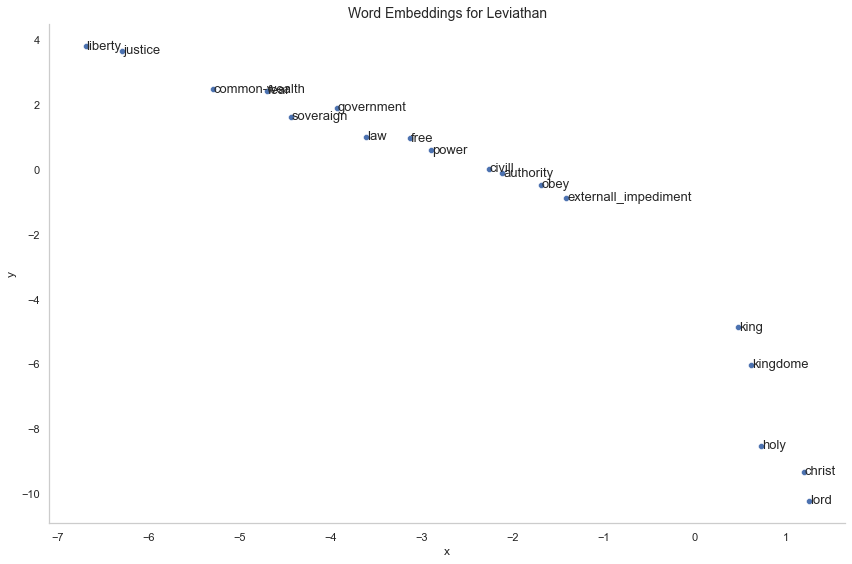

In [61]:
set_seaborn_style()
plt.figure(figsize=(12,8))
word_plot = sns.scatterplot(data=df,x='x',y='y')
word_plot.grid(False)
#word_plot.set_xlim(xlim)
#word_plot.set_ylim(ylim)
sns.despine(bottom=False, left=False, right=True, top=True)
#word_plot.set_xticks([])
#word_plot.set_yticks([])
word_plot.set_title("Word Embeddings for Leviathan", fontdict={'size':14})
hptutil.label_points(df['x'], df['y'], df['token'], plt.gca(), x_offset=0.01)
#plt.arrow(0.99,1.76,1,1,width=0.01,head_width=0.1,head_length=0.1,length_includes_head=True,color='black')
#plt.annotate("", xy=(0.99, 1.76), xytext=(1.96, -0.45), arrowprops=dict(arrowstyle="->",color='black'))
plt.tight_layout()
svg_fpath = os.path.join(fig_path, "lev_embeddings.svg")
plt.savefig(svg_fpath)

In [62]:
df.index.name

In [63]:
if df.index.name != "token":
    df.set_index("token", inplace=True)
latex_str = hptutil.custom_latex_export(df, self_contained=True, debug=True)
with open("hobbes_standalone.tex", 'w', encoding='utf-8') as outfile:
    outfile.write(latex_str)

Adding authority
cur_pd (PointData): PointData[x=-2.1152288913726807,y=-0.1221897229552269,label=authority,anchor=north]
[point_str()] self.label = authority
Adding christ
cur_pd (PointData): PointData[x=1.1991099119186401,y=-9.320261001586914,label=christ,anchor=north]
[point_str()] self.label = christ
Adding civill
cur_pd (PointData): PointData[x=-2.261406660079956,y=0.020989974960684776,label=civill,anchor=north]
[point_str()] self.label = civill
Adding common-wealth
cur_pd (PointData): PointData[x=-5.300451755523682,y=2.4736626148223877,label=common-wealth,anchor=north]
[point_str()] self.label = common-wealth
Adding externall_impediment
cur_pd (PointData): PointData[x=-1.4107270240783691,y=-0.8793035745620728,label=externall_impediment,anchor=north]
[point_str()] self.label = externall_impediment
Adding fear
cur_pd (PointData): PointData[x=-4.704436779022217,y=2.4263739585876465,label=fear,anchor=north]
[point_str()] self.label = fear
Adding free
cur_pd (PointData): PointData[x=-3

## tSNE

In [64]:
cur_model = lev_model

tsne_vecs = cur_model.wv.vectors
tsne_vecs_normed = cur_model.wv.get_normed_vectors()
# Change this to change whether it uses normed vectors
tsne_vec_df = pd.DataFrame(tsne_vecs_normed, index=cur_model.wv.index_to_key)
tsne_vec_df

,0,1
man,-0.995214,0.097717
god,0.042193,-0.999109
law,-0.963534,0.267584
one,-0.993808,0.111112
power,-0.980017,0.198915
...,...,...
rectitude,-0.996307,-0.085868
furnishes,-0.993698,0.112091
encourageth,-0.995057,0.099302
circumspection,-0.870298,0.492525


In [82]:
tsne_N = 8000
top_n_tokens = [t[0] for t in lev_token_counts[:tsne_N]]
tsne_topn_df = tsne_vec_df[tsne_vec_df.index.isin(top_n_tokens)].copy()
tsne_topn_df

,0,1
man,-0.995214,0.097717
god,0.042193,-0.999109
law,-0.963534,0.267584
one,-0.993808,0.111112
power,-0.980017,0.198915
...,...,...
rectitude,-0.996307,-0.085868
furnishes,-0.993698,0.112091
encourageth,-0.995057,0.099302
circumspection,-0.870298,0.492525


In [83]:
[t for t in tsne_topn_df.index if "extern" in t]

['externall', 'externall_impediment', 'externo']

In [84]:
from sklearn.manifold import TSNE

In [85]:
tsne = TSNE(n_components=2, random_state=global_seed,
            metric='cosine',
            learning_rate=10,
            perplexity=12.0, n_jobs=8,
            n_iter=2000)

In [86]:
#timeit -r1 -n1
# Project the data in 2D
#X_tsne = tsne.fit_transform(wpa_vecs)

# Convert df to just nunmeric matrix
#X_wpa_kw = wpa_kw_df.drop(columns=['token'])
X_tsne_topn = tsne.fit_transform(tsne_topn_df)

C:\Users\jpjac\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [87]:
tsne_df_full = pd.DataFrame(X_tsne_topn, columns=['x','y'], index=tsne_topn_df.index)
tsne_df_full

,x,y
man,42.185413,-30.103691
god,-52.609283,6.512658
law,46.503422,34.586960
one,26.029749,-63.992344
power,-24.624355,-46.391071
...,...,...
rectitude,11.664919,67.774620
furnishes,25.919928,-64.655861
encourageth,34.441639,-50.910622
circumspection,66.732483,-49.117222


In [88]:
# Now just the keywords
#kw_remove = ['freedom', 'slavery']
#kw_filtered = [kw for kw in keywords if kw not in kw_remove]
#kw_add = ['baby', 'child', 'rich', 'poor']
#kw_final = kw_filtered + kw_add
tsne_df = tsne_df_full[tsne_df_full.index.isin(keywords)].copy()

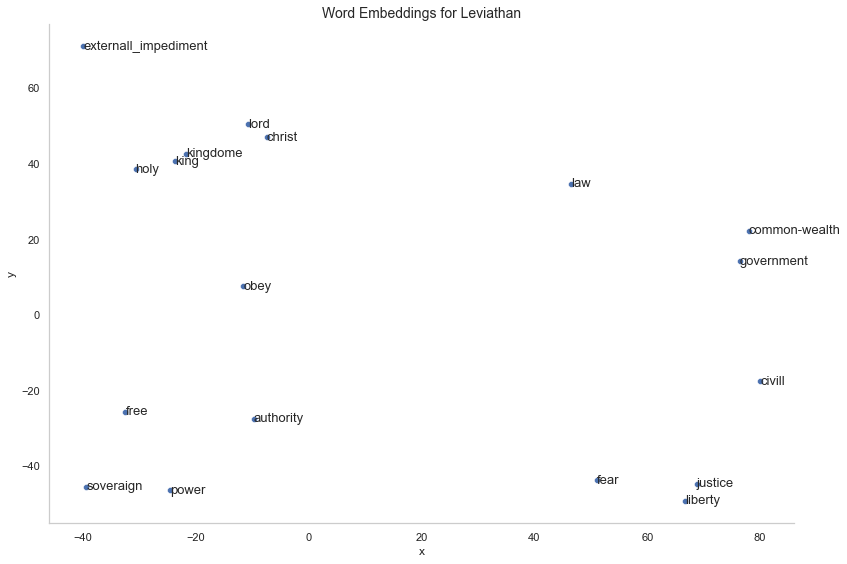

In [92]:
# Plot tSNE like it's the 2d space
set_seaborn_style()
plt.figure(figsize=(12,8))
word_plot = sns.scatterplot(data=tsne_df,x='x',y='y')
word_plot.grid(False)
#word_plot.set_xlim(tsne_xlim)
#word_plot.set_ylim(tsne_ylim)
sns.despine(bottom=False, left=False, right=True, top=True)
#word_plot.set_xticks([])
#word_plot.set_yticks([])

#plt.arrow(0.99,1.76,1,1,width=0.01,head_width=0.1,head_length=0.1,length_includes_head=True,color='black')
#plt.annotate("", xy=(0.99, 1.76), xytext=(1.96, -0.45), arrowprops=dict(arrowstyle="->",color='black'))
word_plot.set_title("Word Embeddings for Leviathan", fontdict={'size':14})
hptutil.label_points(tsne_df['x'], tsne_df['y'], tsne_df.index, plt.gca(), x_offset=0.01)
plt.tight_layout()

In [98]:
# tex export
tsne_df
latex_str = hptutil.custom_latex_export(tsne_df, self_contained=True, debug=True, pad_pct=0.2)
with open("hobbes_tsne_standalone.tex", 'w', encoding='utf-8') as outfile:
    outfile.write(latex_str)

Adding law
cur_pd (PointData): PointData[x=46.503421783447266,y=34.58695983886719,label=law,anchor=north]
[point_str()] self.label = law
Adding power
cur_pd (PointData): PointData[x=-24.62435531616211,y=-46.39107131958008,label=power,anchor=north]
[point_str()] self.label = power
Adding soveraign
cur_pd (PointData): PointData[x=-39.39225387573242,y=-45.462982177734375,label=soveraign,anchor=north]
[point_str()] self.label = soveraign
Adding common-wealth
cur_pd (PointData): PointData[x=77.98419952392578,y=22.16880226135254,label=common-wealth,anchor=north]
[point_str()] self.label = common-wealth
Adding christ
cur_pd (PointData): PointData[x=-7.418119430541992,y=46.909645080566406,label=christ,anchor=north]
[point_str()] self.label = christ
Adding king
cur_pd (PointData): PointData[x=-23.69881820678711,y=40.56747817993164,label=king,anchor=north]
[point_str()] self.label = king
Adding civill
cur_pd (PointData): PointData[x=80.02437591552734,y=-17.630285263061523,label=civill,anchor=nor

## Now same for pre-Leviathan texts